# Transfer learning demo

In this demo we show the basic steps of transfer learning. The code is written for clarity, not compactness or performances. The main target is to make you easily able to follow along. Here's the steps:


1. download an [insect classification dataset](https://www.kaggle.com/datasets/yashdogra/insectv2-dataset) from kaggle
2. download an already-trained network ([vgg16](https://keras.io/api/applications/vgg/)) from keras library
3. freeze the network, add a few custom layers so that it can properly work with our data
4. train and evaluate the network performances
5. for comparison, repeat the last two steps but with a blank (*i.e* untrained) network that we are going to train from scratch



# 0) Parameters

We fix a few standard parameters, which will then be used all along the code

In [1]:
#we just know that the images we are going to use have this size
img_rows, img_cols = 150, 150
#RGB images -> 3 color channels
input_shape = (img_rows, img_cols, 3)

#standard training config
batch_size = 32
n_epochs = 15
verbosity = 1

#this for code reproducibility
seed = 0
from tensorflow import keras
keras.utils.set_random_seed(seed)

# 1) Download the insect dataset

We use `kagglehub` package, which comes with standard functions for data download

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashdogra/insectv2-dataset")

print("Path to dataset files:", path)

# directories
train_folder = path + '/pest/train'
val_folder = path + '/pest/test'

100%|██████████| 61.2M/61.2M [00:00<00:00, 180MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yashdogra/insectv2-dataset/versions/2


We create to `dataset` objects using [keras functions](https://keras.io/api/data_loading/image/#image_dataset_from_directory-function) for reading data from a directory

In [3]:
#this will contain the training data
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_folder,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_rows, img_rows),
    shuffle=True,
    seed=seed
    )

#this will contain the validation data
val_ds = keras.utils.image_dataset_from_directory(
    directory=val_folder,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_rows, img_rows),
    shuffle=True,
    seed=seed
    )

Found 2232 files belonging to 9 classes.
Found 384 files belonging to 9 classes.


# 2) Download the big, already trained model

The model we are going to use is vgg16. Not the biggest one available, or the most recent one, but still decent (and agile enough for a demo). Notice that when we download a trained network we need to specify what set of weights should be downloaded. In this case we chose a network trained on the famous [imagenet object recognition dataset](https://paperswithcode.com/dataset/imagenet)

In [4]:
from tensorflow.keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's take a look at the structure of the newtork

In [5]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# 3) Freeze, add top

The network we downloaded has 19 layers and 14.7 millions of trainable parameters. We want to freeze it and use it as it is packed, not retrain everything.


In [6]:
#freezing the cloned copy, one layer at a time
vgg.trainable = False
for layer in vgg.layers:
  layer.trainable = False

#taking a look now that it's frozen
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

The structure is the same as before freezing, but now the number of trainable parameters dropped to zero. Perfect!

Let's build a new network with the frozen vgg model followed by a few standard dense layers.

In [7]:
from keras.layers import Dense, Dropout, Flatten

#a new, empty model
model = keras.models.Sequential()

#adding the frozen vgg model
model.add(vgg)

#a few layers to finalize
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

#the dataset has nine classes, so the final layer needs to have 9 nodes
model.add(Dense(9, activation='softmax'))

#let's take a look
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,176,777 (73.15 MB)

 Trainable params: 4,462,089 (17.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

The model still manages to pack about 4.5 millions trainable parameters. That's because the very first layer we added after the `flatten` has 512 nodes, each one receiving 8192 inputs*. The parametes adds up quite quickly!

--

*the exact computation is (8192 inputs + 1 bias) x (512 nodes) = 8193 x 512 = 4194816

# 4) Train and evaluate

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on your dataset
h = model.fit(train_ds, validation_data=val_ds, epochs=n_epochs, batch_size=batch_size, verbose = verbosity)

Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 255ms/step - accuracy: 0.5378 - loss: 12.1068 - val_accuracy: 0.9609 - val_loss: 0.3128
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.9273 - loss: 0.9494 - val_accuracy: 0.9688 - val_loss: 0.5382
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9642 - loss: 0.4185 - val_accuracy: 0.9609 - val_loss: 0.5100
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9698 - loss: 0.4641 - val_accuracy: 0.9688 - val_loss: 0.3767
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9728 - loss: 0.4705 - val_accuracy: 0.9740 - val_loss: 0.6135
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9634 - loss: 0.5583 - val_accuracy: 0.9740 - val_loss: 0.4599
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9693 - loss: 0.7926 - val_accuracy: 0.9740 - val_loss: 0.7897
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9815 - loss: 0.6086 - val_accur

Let's plot the accuracy:

In [9]:
from matplotlib import pyplot
def plot_loss_history(h, metric = 'loss', outfile = None, title = None):
  pyplot.plot(h.history[metric], label = 'Train ' + metric)
  pyplot.plot(h.history['val_' + metric], label = 'Validation ' + metric)
  pyplot.xlabel('Epochs')
  if title is None:
    title = metric
  pyplot.title(title)
  pyplot.legend()
  if outfile is not None:
    pyplot.savefig(outfile, bbox_inches='tight')
  pyplot.show()

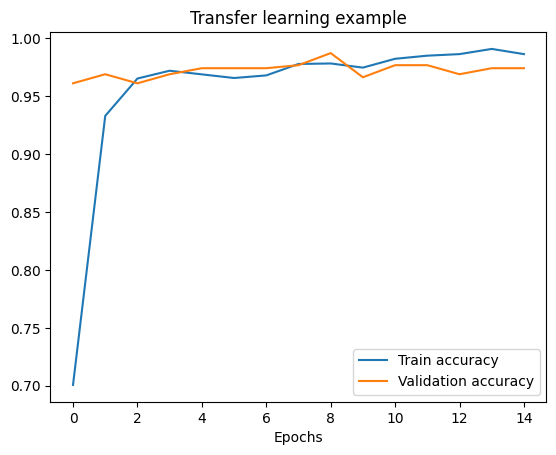

In [10]:
plot_loss_history(h, metric = 'accuracy', title = 'Transfer learning example')

The network works pretty well from the start, with a slow improvement on the training set and no sign of overfitting. For a more polished code we could try different optimizers, use class weights and maybe introduce some image augmentation.


# 5) Let's train the full network

For comparison, let's download a blank vgg network (without the weights) and train it without freezing anything.

In [11]:
#downloading a vgg network without its weights (i.e. random initialization)
vgg_blank = vgg16.VGG16(include_top=False,
                        weights=None, #notice here, previously we were using weights="imagenet"
                        input_shape=input_shape)

We are goingo to build exactly the same architecture as before

In [12]:
#adding the blank vgg, followed by the final, dense layers
model_fully_trainable = keras.models.Sequential()
model_fully_trainable.add(vgg_blank)
model_fully_trainable.add(Flatten())
model_fully_trainable.add(Dense(512, activation='relu'))
model_fully_trainable.add(Dropout(0.3))
model_fully_trainable.add(Dense(512, activation='relu'))
model_fully_trainable.add(Dropout(0.3))
model_fully_trainable.add(Dense(9, activation='softmax'))

#let's take a look
model_fully_trainable.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,176,777 (73.15 MB)

 Trainable params: 19,176,777 (73.15 MB)

 Non-trainable params: 0 (0.00 B)

We now have 19+ millions of trainable parameters.

In [13]:
#compile the model
model_fully_trainable.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train it
h_ft = model_fully_trainable.fit(train_ds, validation_data=val_ds, epochs=n_epochs, batch_size=batch_size, verbose = verbosity)

Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 66s 565ms/step - accuracy: 0.1303 - loss: 16.0053 - val_accuracy: 0.1198 - val_loss: 2.1916
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 265ms/step - accuracy: 0.1266 - loss: 2.1883 - val_accuracy: 0.1302 - val_loss: 2.1919
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 0.1092 - loss: 2.1890 - val_accuracy: 0.1302 - val_loss: 2.1916
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - accuracy: 0.1399 - loss: 2.1875 - val_accuracy: 0.1302 - val_loss: 2.1915
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.1175 - loss: 2.2410 - val_accuracy: 0.1302 - val_loss: 2.1909
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.1243 - loss: 2.2048 - val_accuracy: 0.1302 - val_loss: 2.1918
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.1256 - loss: 2.1899 - val_accuracy: 0.1302 - val_loss: 2.1926
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.1366 - loss: 2.1846 - val_acc

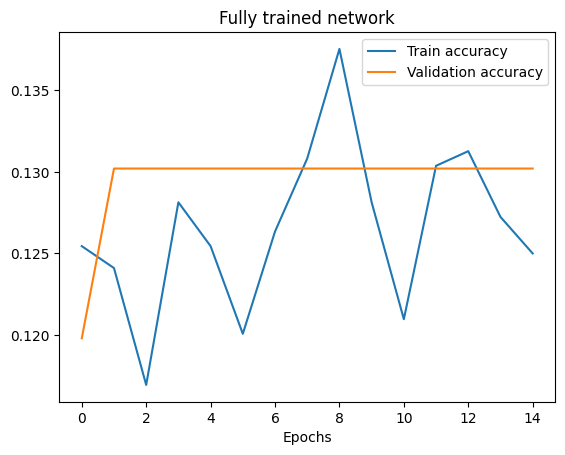

In [14]:
#take a look at how accuracy evolves
plot_loss_history(h_ft, metric = 'accuracy', title = 'Fully trained network')

The network is not learning, and in fact in the validation set is stuck to the majority class. The dataset has nine classes, so by random chance* we expect an accuracy around 1/9 = 11.1%

This comparison highlights how transfer learning can be used to leverage a large network. In particular, we can use it to run a network larger than the one that would be supported by our data.


--

*This is not strictly true because not all classes have the same numerosity, but this dataset is not particularly unbalanced.
